# Predict Distributions - TopDown

Predict timing and size of distributions of ETFs

Apply a TopDown approach with using time-series models on fund level



In [18]:
# General
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re

# File download
from tqdm.notebook import tqdm, trange

# Custom modules
from Tools import S3

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt

# Hidden configurations
from mySecrets import config_file, AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_BUCKET


In [2]:
# Connect to AWS S3 storage
s3 = S3()
s3.connect(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

Connected.


In [3]:
# Download all distribution data
date = "2022_03_24"

# Get list of avilable files -> do not know yet, if all uploads were successful
file_list = s3.listFiles(AWS_BUCKET, "data/distribution_clean/" + date)

# Extract ISIN from filename
df_file = pd.DataFrame(file_list, columns = ['file'])
df_file['ISIN'] = df_file['file'].str.extract(r"([A-Z0-9]{12})", expand = False).fillna('no match')

df_dist = pd.DataFrame(columns = ['Security_ISIN'])

for i, record in tqdm(df_file[0:].iterrows(), total = df_file[0:].shape[0]):

    key = record['file']
    isin = record['ISIN']

    filename = './temp/' + isin + ".tsv"

    s3.downloadFile(AWS_BUCKET, key, filename)

    # Read tsv file
    df_temp = pd.read_csv(filename, sep = "\t")

    # Rename columns
    df_temp = df_temp.rename(columns={
        'ExTag': 'Dist_Date_Ex',
        'Fälligkeitsdatum': 'Dist_Date_Payment',
        'Stichtag': 'Dist_Date_Record',
        'ISIN': 'Security_ISIN',
        'Dist': 'Dist_Amount'
    })

    df_dist = df_dist.append(df_temp)

  0%|          | 0/141 [00:00<?, ?it/s]

In [4]:
# Adjust order of columns
df_dist = df_dist[['Security_ISIN', 'Dist_Amount', 'Dist_Date_Ex', 'Dist_Date_Record', 'Dist_Date_Payment']]
df_dist.head()

,Security_ISIN,Dist_Amount,Dist_Date_Ex,Dist_Date_Record,Dist_Date_Payment
0,IE0005042456,0.0427,2022-03-17,2022-03-18,2022-03-30
1,IE0005042456,0.0480,2021-12-16,2021-12-17,2021-12-31
2,IE0005042456,0.0855,2021-09-16,2021-09-17,2021-09-29
3,IE0005042456,0.0813,2021-06-17,2021-06-18,2021-06-30
4,IE0005042456,0.0562,2021-03-11,2021-03-12,2021-03-24


In [9]:
# Format dates
# Ex < Record < Payment

# # Select all observations, where all 3 dates are available
df_dist_dates = df_dist.dropna(subset=['Dist_Date_Ex', 'Dist_Date_Record', 'Dist_Date_Payment'], how='any').copy()

# # Transform all date columns to datetime
# from datetime import datetime
# import locale

# # Datetime doesnot recognie "Mär"|"Mar" with german locale de_DE
# locale.setlocale(locale.LC_ALL, 'en_US')

# d = {'Mär':'Mar', 'Mai':'May','Okt':'Oct','Dez':'Dec'}

df_dist_dates['Dist_Date_Ex'] = pd.to_datetime(df_dist_dates['Dist_Date_Ex'], format="%Y-%m-%d")
df_dist_dates['Dist_Date_Record'] = pd.to_datetime(df_dist_dates['Dist_Date_Record'], format="%Y-%m-%d")
df_dist_dates['Dist_Date_Payment'] = pd.to_datetime(df_dist_dates['Dist_Date_Payment'], format="%Y-%m-%d")

df_dist_dates.head()




,Security_ISIN,Dist_Amount,Dist_Date_Ex,Dist_Date_Record,Dist_Date_Payment
0,IE0005042456,0.0427,2022-03-17,2022-03-18,2022-03-30
1,IE0005042456,0.0480,2021-12-16,2021-12-17,2021-12-31
2,IE0005042456,0.0855,2021-09-16,2021-09-17,2021-09-29
3,IE0005042456,0.0813,2021-06-17,2021-06-18,2021-06-30
4,IE0005042456,0.0562,2021-03-11,2021-03-12,2021-03-24


## Map daily data to quarters

The forecast model will operate on quarterly data. For this, the available daily data needs to be mapped onto quarters.

For this, we assign custom quarters which take into account the nature of accounting. And will rather be data-driven than follow the usual defintion of quarters.

Meaning, there will be 1,2 or 4 distributions in a year from each fund. The actual timing of the distributions must not coincide with the usual definition of quarters.
For example, a fund with 4 distributions in year, could have the second distribution always around the end of march. When, for whateve reason, the distribution is delayed by some days to the 2nd of April for example, this distribution could be assigned to the second quarter. Now, our model would think that there would be only 3 quarters with distributions in that year.
Even though, there are 4, and the difference in days between the second and third distributions only changed by a few days.

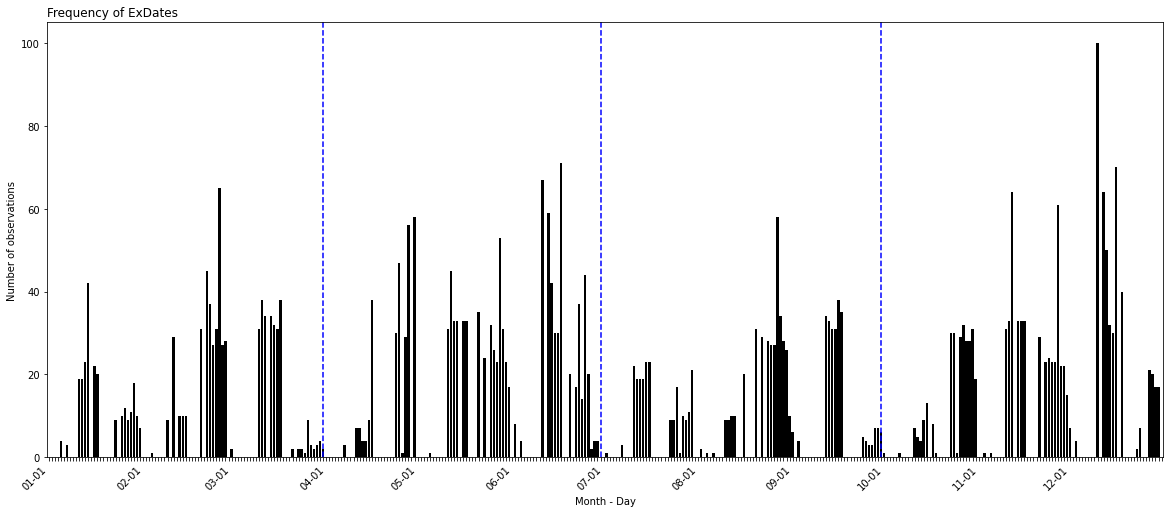

In [10]:
# Inspect the distribution of observations - Ex Date

df_plot = df_dist_dates[['Security_ISIN', 'Dist_Date_Ex']].rename(columns={'Dist_Date_Ex':'Date'}).copy()

# Extract month_day from date and add dummy year
df_plot['Date'] = [str(d) + "_" + str(m) + "_2000" for m,d in zip(df_plot.Date.dt.month, df_plot.Date.dt.day)]

# Transform to datetime
df_plot['Date'] = pd.to_datetime(df_plot['Date'], format="%d_%m_%Y")

# Aggregate by date
df_plot = df_plot.groupby('Date').size().reset_index(name='obs')

# Add possibly missing dates
idx = pd.date_range('2000-01-01', '2000-12-31')
df_plot = pd.DataFrame(data={'Date': idx}).join(df_plot.set_index('Date'), on = 'Date')

# Replace NA
df_plot = df_plot.fillna(0)

dates = list(df_plot.Date.dt.strftime('%m-%d'))

# # # Draw the graph
fig = plt.figure(figsize=(20, 8))

# # # # Cannot use histplot; need column plot
ax = sns.barplot(data=df_plot, x='Date', y='obs', color='black')

# Custom x labels -> display first day of the month?
x_lab = [d.strftime('%m-%d') if d.day == 1 else "" for d in df_plot.Date]
ax.set_xticklabels(labels=x_lab, rotation=45, ha='right')

# Add vertical lines for actual end of quarters
plt.axvline(x = dates.index('03-31'), color='blue', ls='--')
plt.axvline(x = dates.index('06-30'), color='blue', ls='--')
plt.axvline(x = dates.index('09-30'), color='blue', ls='--')

# Add vertical lines for newly assigned end of quarters
# TODO: Do not need to reassign quarters!

plt.title("Frequency of ExDates", loc='left')

plt.xlabel('Month - Day')
plt.ylabel('Number of observations')

plt.show()


In [11]:
# Aggregate daily data to quarters
df_temp = df_dist_dates[['Security_ISIN', 'Dist_Date_Ex', 'Dist_Amount']].rename(columns={'Dist_Date_Ex':'Date'}).copy()

df_temp['Year'] = df_temp.Date.dt.year

def transDateToQuarter(month, day):

    # Define cut off date, i.e. how many days after a quarter are still assigned to the last quarter
    cut = 0

    if ((month == 1) & (day > cut)) | (month == 2) | (month == 3) | ((month == 4) & (day <= cut)):
        return(1)
    elif ((month == 4) & (day > cut)) | (month == 5) | (month == 6) | ((month == 7) & (day <= cut)):
        return(2)
    elif ((month == 7) & (day > cut)) | (month == 8) | (month == 9) | ((month == 10) & (day <= cut)):
        return(3)
    else:
        return(4)

df_temp["Q"] = [transDateToQuarter(m, d) for m, d in zip(df_temp.Date.dt.month, df_temp.Date.dt.day)]

# Create year-q combi
df_temp["Y_Q"] = [str(i) + "Q" + str(j) for i,j in zip(df_temp['Year'], df_temp['Q'])]

# Format as datetime(year, quarter)
# pd.to_datetime(df_temp.Y_Q, format = "%YQ%q")
df_temp["Y_Q"] = pd.PeriodIndex(df_temp.Y_Q, freq = 'Q')


# # # Change typ of dist column to numeric
df_temp[df_temp.Dist_Amount == "--"] = "0"
df_temp['Dist_Amount'] = df_temp.Dist_Amount.astype(float)

# # # Group by new column
df_temp = df_temp.groupby(['Security_ISIN', 'Y_Q', 'Year']).agg({'Dist_Amount': 'sum'}).reset_index()

df_temp = df_temp[~(df_temp.Security_ISIN == "0")]

df_temp["Y_Q"] = pd.PeriodIndex(df_temp.Y_Q, freq='Q').to_timestamp()

df_temp.head()


,Security_ISIN,Y_Q,Year,Dist_Amount
0,IE0005042456,2000-07-01,2000,0.0637
1,IE0005042456,2000-10-01,2000,0.0229
2,IE0005042456,2001-01-01,2001,0.0188
3,IE0005042456,2001-04-01,2001,0.1014
4,IE0005042456,2001-07-01,2001,0.0443


## Inspect distribution patterns

Inspect different type of distribution behaviors

* Do we have upward / downward trends?
* Are there outliers; maybe due to high one-time payments
* Is there erratic behavior? Is the distribution even predictable with a top-down approach?

And how does this look like on a quarterly vs yearly perspective? As is and for moving average/sum?

Can we predict on ??? :
* Quarterly
* Yearly
* Moving averages/sum

How to evaluate a good model? RMSE? MAPE?

IE00B0M63391
IE00B0M63623
IE00B14X4Q57
IE00B14X4S71
IE00B66F4759
IE00B74DQ490
IE00B7J7TB45
IE00BD45KH83
IE00BFM15T99
IE00BJ5JPJ87
IE00BL977C92
IE00BYXZ2585


<Figure size 1440x576 with 0 Axes>

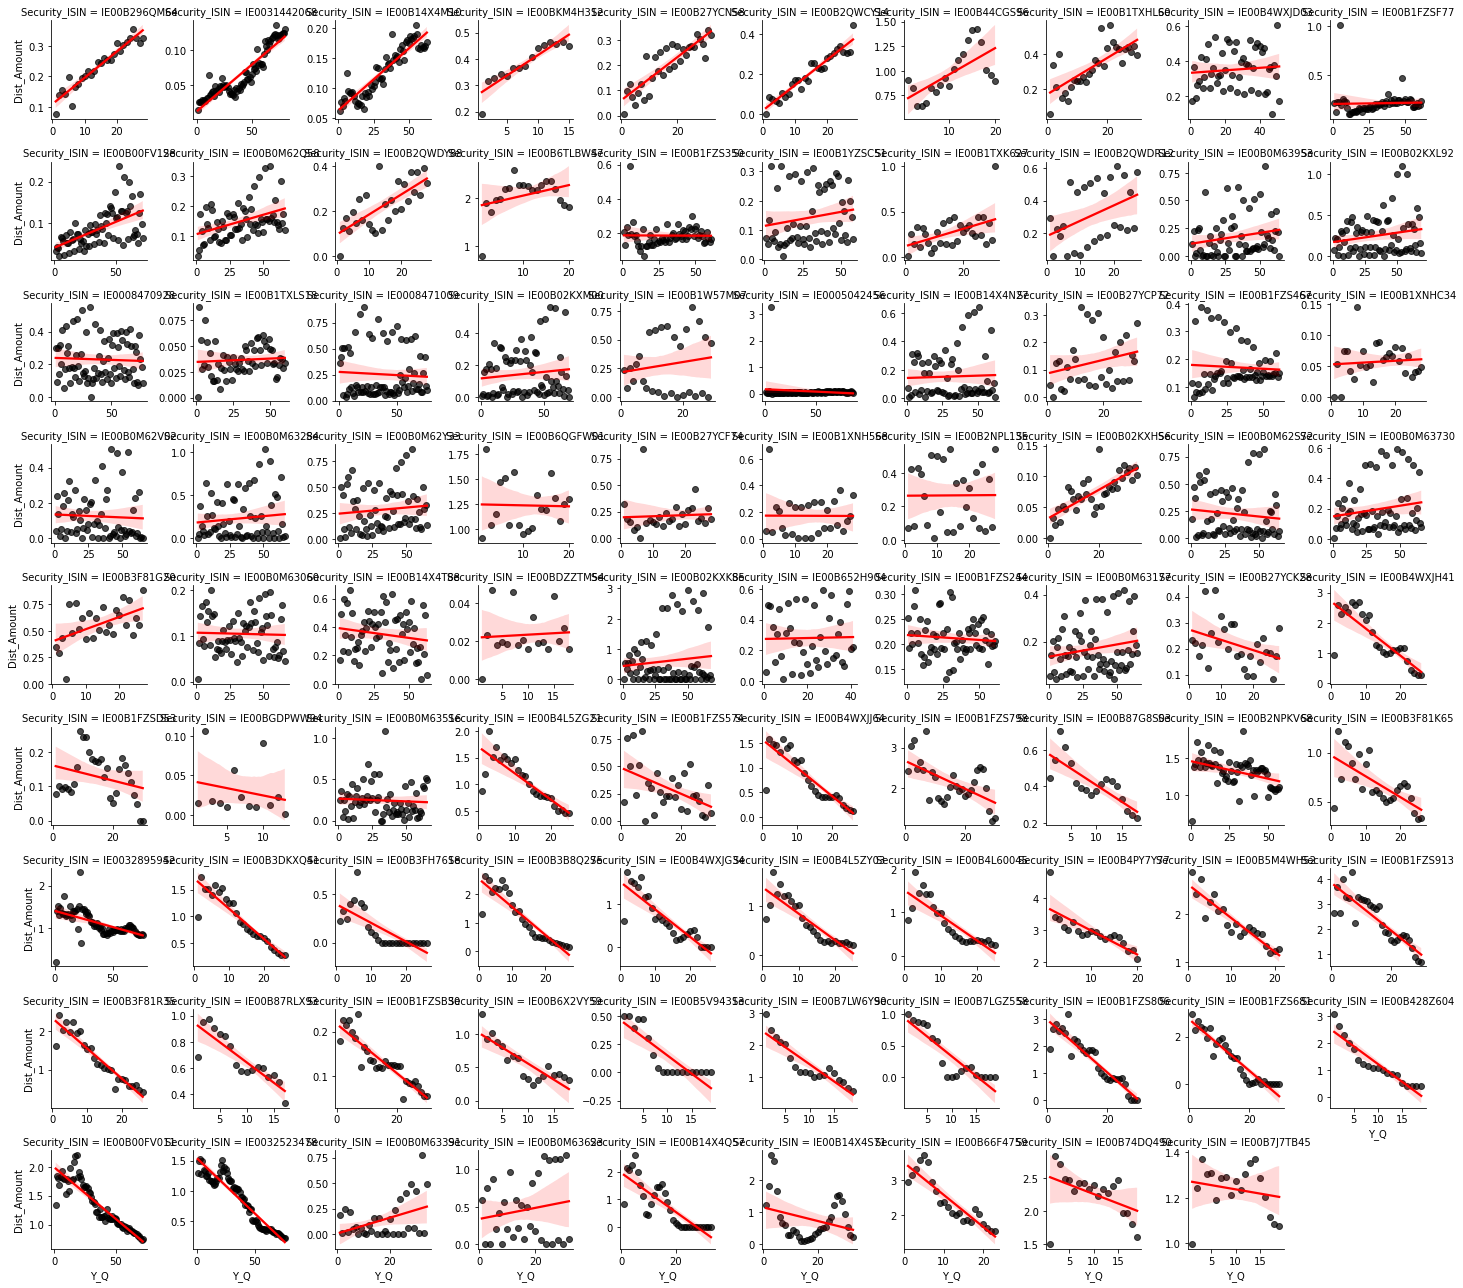

In [12]:
# Find and define different patterns

# Arrange scatter plots by correlation to selected ETF product

import scipy.stats

# Seasonality and somewhat downward trend
# sns.lineplot(data = df_temp[df_temp.Security_ISIN == 'IE0008471009'], x = "Y_Q", y = 'Dist_Amount')

# Discontinue of distributions -> paid for several years and then stopped
# No trend at all -> random cloud of data points
# ---> ???


# replace timestampe Y_Q with counter so that poly_fit can work
df_plot = df_temp.copy()
df_plot['Y_Q'] = df_plot.groupby('Security_ISIN').cumcount() + 1

# Filter to securities with at least 3 years of data, i.e. Y_Q > 12
df_plot_filter = df_plot.groupby('Security_ISIN')['Y_Q'].max().reset_index()
df_plot_filter = df_plot_filter[df_plot_filter.Y_Q > 12]
df_plot = df_plot[df_plot.Security_ISIN.isin(df_plot_filter.Security_ISIN)]


# Sort ISINS by highest correlation to benchmark isin
isin_bench = "IE00B296QM64"
isin_list = df_temp.Security_ISIN.unique()
isin_dict = {}

df_bench = df_temp[df_temp.Security_ISIN == isin_bench][['Y_Q', 'Dist_Amount']].rename(columns = {'Dist_Amount': 'Dist_Bench'})


for isin_i in isin_list:

    try:
        df_i = df_temp[df_temp.Security_ISIN == isin_i][['Y_Q', 'Dist_Amount']]

        df_i = df_bench.join(df_i.set_index(['Y_Q']), on = 'Y_Q', how = 'inner')

        isin_dict[isin_i] = [scipy.stats.pearsonr(df_i.Dist_Bench, df_i.Dist_Amount)[0]]
    except:
        print(isin_i)

df_sort = pd.DataFrame.from_dict(isin_dict)
df_sort = pd.DataFrame(df_sort.loc[0,])
df_sort.reset_index(inplace = True)
df_sort.columns = ['Security_ISIN', 'Cor']
df_plot = df_plot.join(df_sort.set_index('Security_ISIN'), on = 'Security_ISIN', how = 'left').sort_values(['Cor', 'Y_Q'], ascending = [False, True])


# # # Draw the graph
fig = plt.figure(figsize=(20, 8))

g = sns.FacetGrid(df_plot, col="Security_ISIN", col_wrap=10, height=2, sharey=False, sharex=False)
g.map(sns.regplot, "Y_Q", "Dist_Amount", order=1, scatter_kws={"color": "black", "alpha": 0.7}, color = "red")


## Inspect time series properties

Check Partial Autocorrelation, etc.

Check stationarity

Need these checks to determine which models might be appropriate and which features need to go into the model

### Augmented-Dickey-Fuller Test

In [37]:
from statsmodels.tsa.stattools import adfuller

def calc_adfuller(x_):

    x_d = np.diff(x_)

    # Check time series as is
    level_c = adfuller(x_)[1]

    # Check with trend
    level_ct = adfuller(x_, regression="ct")[1]

    # Check first differences
    diff_c = adfuller(x_d)[1]

    # Check first differences with trend
    diff_ct = adfuller(x_d, regression="ct")[1]

    return [level_c, level_ct, diff_c, diff_ct]

# Collect all results
dict_adfuller = {}

for isin_i in df_temp.Security_ISIN.unique():

    x_ = df_temp[df_temp.Security_ISIN == isin_i]['Dist_Amount']

    if (len(x_)) > 8:

        dict_adfuller[isin_i] = calc_adfuller(x_)



df_adfuller = pd.DataFrame.from_dict(dict_adfuller, orient="index", columns=['level_c', 'level_ct', 'diff_c', 'diff_ct'])


<Figure size 1440x576 with 0 Axes>

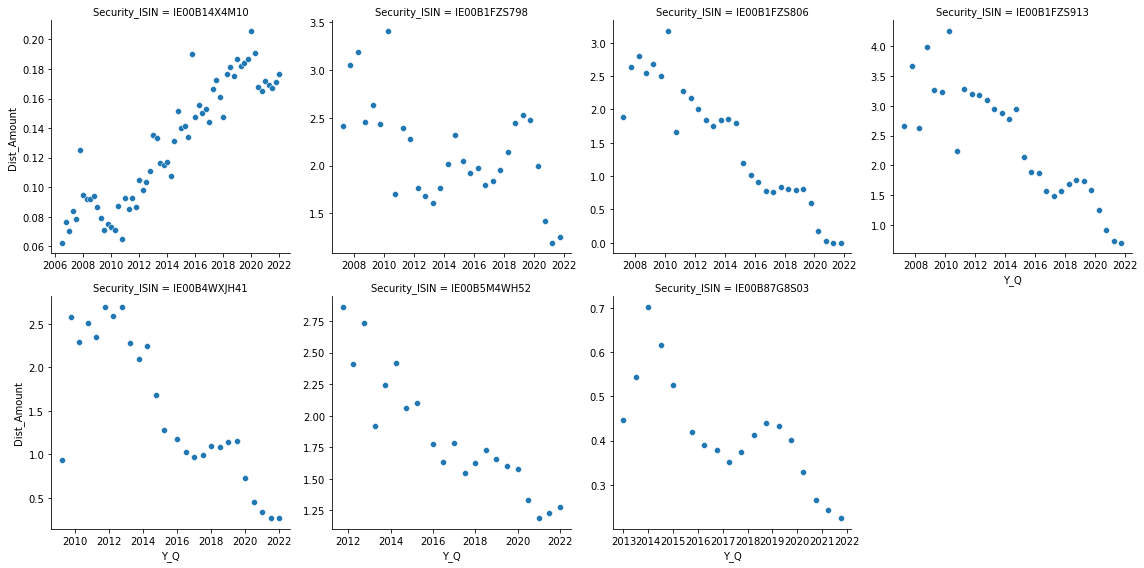

In [52]:
# Find problematic observations, i.e. where none of the adfuller tests rejects the H0

df_adfuller_problems = df_adfuller[(df_adfuller.level_c > 0.05) & (df_adfuller.level_ct > 0.05) & (df_adfuller.diff_c > 0.05) & (df_adfuller.diff_ct > 0.05)]

df_adfuller_plot = df_temp.copy()

df_adfuller_plot = df_adfuller_plot[df_adfuller_plot.Security_ISIN.isin(df_adfuller_problems.index)]

fig = plt.figure(figsize=(20, 8))

g = sns.FacetGrid(df_adfuller_plot, col="Security_ISIN", col_wrap=4, height=4, sharey=False, sharex=False)
g.map(sns.scatterplot, "Y_Q", "Dist_Amount")

# It looks like changes in the distribution policy. Seasonal distrbutions in the beginning, and then more evenly distributed over quarters
# And also not linear trends. Trend follows some poly-fit.

# But, luckily, only 9 observations seem problematic! And, from the visuals, those should be well approximated by linear trends.

### (Partial) Autocorrelation

Check how many lags are relevant for time series

In [53]:
##adfasdf

## Setup testing framework

Need framework to quickly assess the quality of a forecast model.

Need to check:
* Backtesting results
* Train vs Test performance
* Out-of-sample performace -> how does the model behave for the next N Quarters. Does it get negative? Does it explode?

In [ ]:
# adfadsf

## Try different models

Compare different models for their ability to predict distributions

Test:
* Base Case: T = (T-1) -> simple lagged model
* Linear Regression
* Random Forest Regressor
* SARIMA
